# Predicting the Severity of Road Traffic Collisions

## Using machine learning methods to determine the most important factors in determining the severity of road traffic collisions

The purpose of this notebook is to gather and explore data related to road traffic collisions in the United Kingdom.  Furthermore, to conduct analysis on the data to determine the combination of factors that lead to the most severe outcomes.

A model of this nature could be used for example to support the insurance industry to determine premium prices.  Similarly, a model of this nature could be used to direct road safety campaigns or interventions toward the factors leading to the most serious of incidents. 

## Data
This data is taken from Kaggle.  It is part of a dataset owned and maintained by the UK's Department for transport. 

UK police forces collect data on every vehicle collision in the uk on a form called Stats19. Data from this form ends up at the DfT and is published at https://data.gov.uk/dataset/road-accidents-safety-data.  

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import tree, ensemble
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Use the warnings module to filter out warnings
warnings.filterwarnings('ignore')

In [2]:
# Import and manage the data
# Data is taken from https://data.gov.uk/dataset/road-accidents-safety-data
# Data is supplied as 3 separate files, vehicles, casualties and accidents

# Using the try_except block to handle errors in the data loading
file_path_cas = 'Casualties0515.csv'
try:
    df_cas = pd.read_csv(file_path_cas, on_bad_lines='skip')
except Exception as e:
    print(f"An error occurred: {e}")

file_path_veh = 'Vehicles0515.csv'
try:
    df_veh = pd.read_csv(file_path_veh, on_bad_lines='skip')
except Exception as e:
    print(f"An error occurred: {e}")
    
file_path_acc = 'Accidents0515.csv'
try:
    df_acc = pd.read_csv(file_path_acc, on_bad_lines='skip')
except Exception as e:
    print(f"An error occurred: {e}")
    

In [3]:
# Merge the three dataframes based on Accident_Index

# First, merge df_veh and df_acc
df_merged_1 = pd.merge(df_veh, df_acc, on='Accident_Index', how='inner')
# Now, merge the result with df_cas
df_merged = pd.merge(df_merged_1, df_cas, on='Accident_Index')

# Check the data
df_merged.head()

,Accident_Index,Vehicle_Reference_x,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,9,0,18,0,0,0,0,0,...,37,7,2,1,1,0,0,-1,0,1
1,200501BS00002,1,11,0,4,0,3,0,0,0,...,37,7,3,0,0,0,4,-1,11,1
2,200501BS00003,1,11,0,17,0,0,0,4,0,...,62,9,3,0,0,0,0,-1,9,1
3,200501BS00003,2,9,0,2,0,0,0,0,0,...,62,9,3,0,0,0,0,-1,9,1
4,200501BS00004,1,9,0,18,0,0,0,0,0,...,30,6,3,5,2,0,0,-1,0,1


In [4]:
# Check the number of entries
len(df_merged)

4287593

##### Data

My initial approach was to select the features i felt were most likely to offer the best results.  However, while this worked, it provided an accuracy that wasn't acceptable approximately 48%.

For this reason, I decided to take another approach using recursive feature elimination

In [5]:
# Only keep the columns I need to keep
# Columns to keep
columns_to_keep = ['Vehicle_Type', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area',]  

# Create a new DataFrame with only the selected columns
df = df_merged[columns_to_keep]

# Create new dataframes to work with
# df to run in the models
df_model = df.copy()
# df to explore the data
df_graph = df.copy()

# Ensure 'Casualty_Severity' is the last column
columns = df_model.columns.to_list()
columns.remove('Casualty_Severity')
df_model = df_model[columns + ['Casualty_Severity']]
df_model.head()

# Check the data
df.head()

,Vehicle_Type,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
0,9,1,7,2,1,2,2,1
1,11,1,7,3,4,1,1,1
2,11,1,9,3,4,1,1,1
3,9,1,9,3,4,1,1,1
4,9,1,6,3,1,1,1,1


In [6]:
# Check for missing values
missing_values = df.isna().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 Vehicle_Type               0
Sex_of_Casualty            0
Age_Band_of_Casualty       0
Casualty_Severity          0
Light_Conditions           0
Weather_Conditions         0
Road_Surface_Conditions    0
Urban_or_Rural_Area        0
dtype: int64


##### Exploring the data

At this stage, it is worth learning a bit more about the data being used.  The following code defines a function to plot a number of different features against severity to understand how the results could be expected to manifest

In [7]:
# Explore the data
# Function to plot relvant distributions

def plot_data(df, column, title, x_label, y_label, mapping=None):
    if mapping:
        df[f'{column}_Label'] = df[column].map(mapping)
        counts = df[f'{column}_Label'].value_counts()
    else:
        counts = df[column].value_counts()

    counts.plot(kind='bar')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


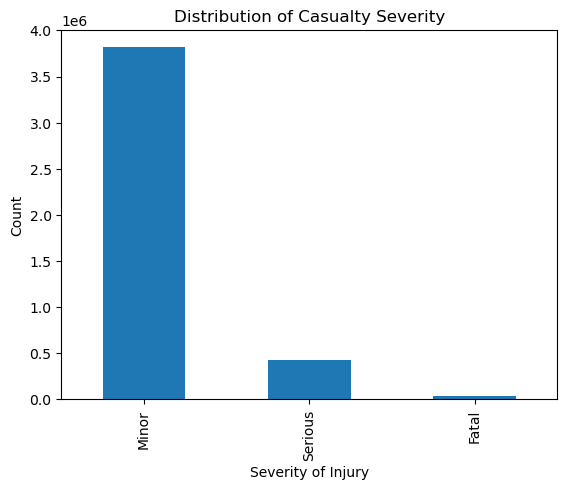

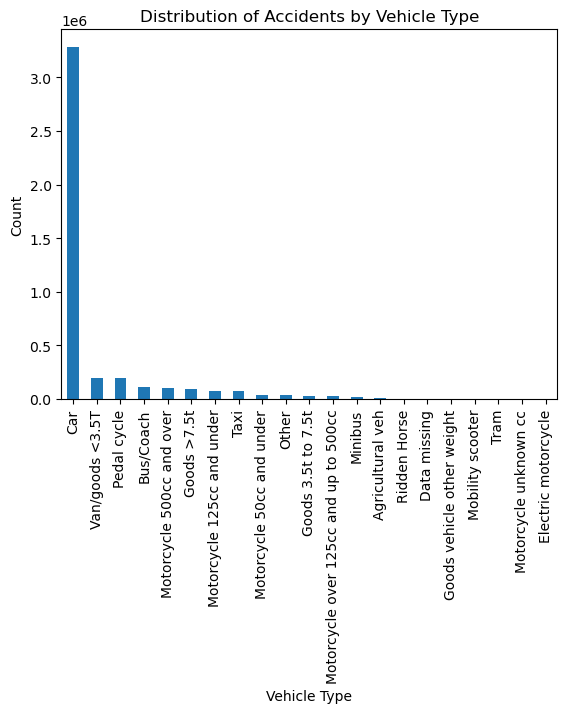

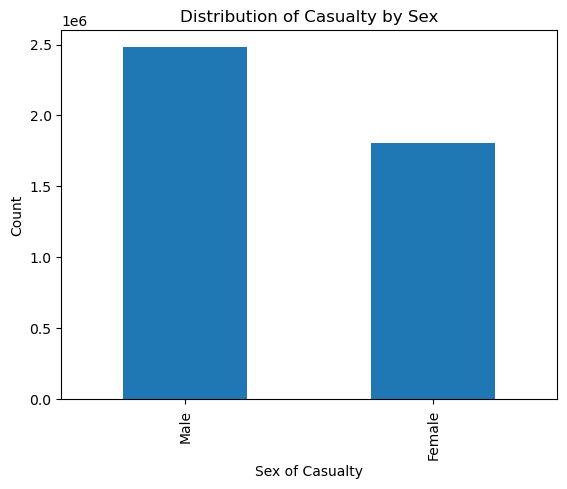

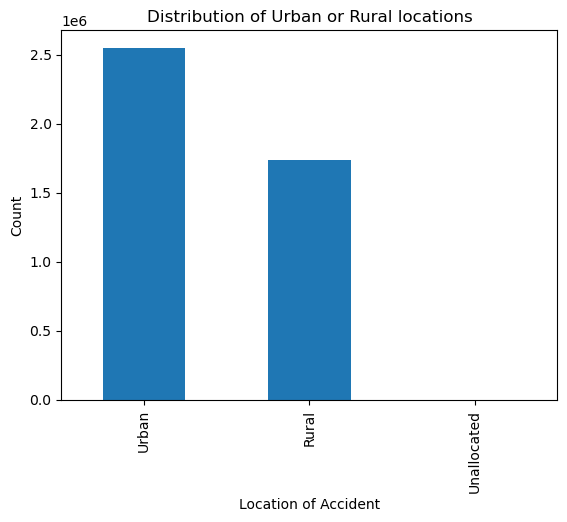

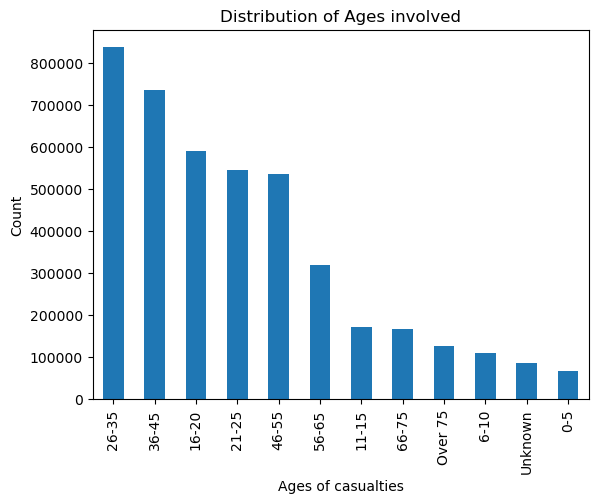

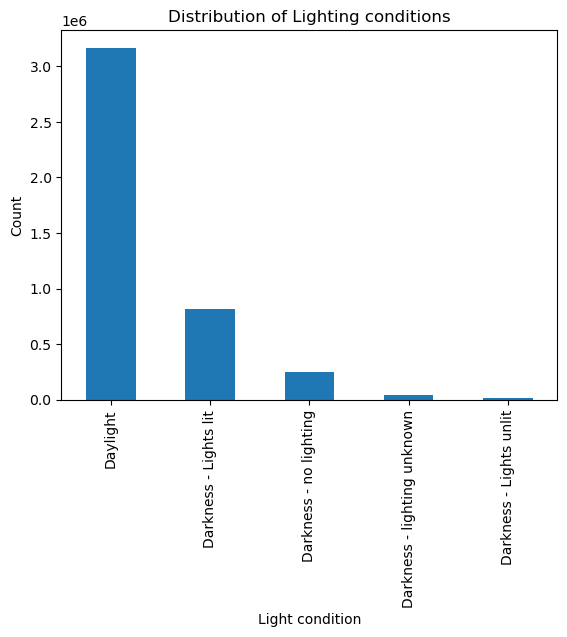

In [8]:
# Plot the graphs

# Plotting Injury Severity
injury_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Minor'}
plot_data(df_graph, 'Casualty_Severity', 'Distribution of Casualty Severity', 'Severity of Injury', 'Count', injury_mapping)

# Plotting Vehicle Type
vehicle_mapping = {1: 'Pedal cycle', 2: 'Motorcycle 50cc and under', 3: 'Motorcycle 125cc and under', 
                   4: 'Motorcycle over 125cc and up to 500cc', 5: 'Motorcycle 500cc and over', 
                   8: 'Taxi', 9: 'Car', 10: 'Minibus', 11: 'Bus/Coach', 16: 'Ridden Horse',
                   17: 'Agricultural veh', 18: 'Tram', 19: 'Van/goods <3.5T', 20: 'Goods 3.5t to 7.5t', 
                   21: 'Goods >7.5t', 22: 'Mobility scooter', 23: 'Electric motorcycle',
                   90: 'Other', 97: 'Motorcycle unknown cc', 98: 'Goods vehicle other weight', -1: 'Data missing'}
plot_data(df_graph, 'Vehicle_Type', 'Distribution of Accidents by Vehicle Type', 'Vehicle Type', 'Count', vehicle_mapping)

# Plotting Sex of Casualty
sex_mapping = {1: 'Male', 2: 'Female'}
plot_data(df_graph, 'Sex_of_Casualty', 'Distribution of Casualty by Sex', 'Sex of Casualty', 'Count', sex_mapping)

# Plotting Urban or rural
loc_mapping = {1: 'Urban', 2: 'Rural', 3: 'Unallocated'}
plot_data(df_graph, 'Urban_or_Rural_Area', 'Distribution of Urban or Rural locations', 'Location of Accident', 'Count', loc_mapping)

# Plotting age of casualties
age_mapping = {-1: 'Unknown', 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 
               5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65',
               10: '66-75',11: 'Over 75'}
plot_data(df_graph, 'Age_Band_of_Casualty', 'Distribution of Ages involved', 
          'Ages of casualties', 'Count', age_mapping)

# Plotting light conditions
light_mapping = {1: 'Daylight', 4: 'Darkness - Lights lit', 5: 'Darkness - Lights unlit', 
               6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown', -1: 'No data'}
plot_data(df_graph, 'Light_Conditions', 'Distribution of Lighting conditions', 
          'Light condition', 'Count', light_mapping)

## Review of the available data

It remains to be seen what conclusions we can draw here.  For example, it is clear that the case majority of accidents occur during the day and involve cars.  This is likely due to more cars being on the road than any other type of vehicle and more vehicles travel during the day.

It may be possible to consider some patterns of incresased number of accidents involving younger drivers, particularly male.

## Importance of features

On the initial pass of this project, simply splitting and applying the date to a decision tree and random forest led to non-specific results.  The data needed resampling due to over valuaing 'minor injuries' due to sheer volume and furthermore, lack of clarity on the importance of features.

For this reason, it is necessary to undertake a number of steps to make the data valuable.  Firstly, resampling the data and then Recursive Feature Elimination

## Resampling using SMOTE

In [9]:
# Split the data for modelling
# Define features and target
X = df_model.drop(columns=['Casualty_Severity'])
y = df_model['Casualty_Severity']

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Need to resample the data based on early calculations

# Creating a SMOTE object
smote = SMOTE()

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


## Decision tree

This is the first application of a model.  This code used Decision Trees.

A decision tree is a machine learning algorithm that represents a sequence of binary decisions used for classification or regression tasks.

Each decision splits the data into subsets based on input features. Its pros include interpretability and ease of visualization, while cons can involve overfitting with complex trees.  It can also be sensitive to to small dataset variations.

Lets just formulate a tree to determine early results

In [10]:
# Fit a single tree 
bestdepth = -1
bestscore = 0

for i in range(10):
    clf = DecisionTreeClassifier(max_depth=i+1)
    clf = clf.fit(X_train_resampled, y_train_resampled )
    y_pred = clf.predict(X_test)
    trainscore = clf.score(X_train_resampled, y_train_resampled )
    valscore = clf.score(X_val, y_val)
    print('Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)
    if valscore > bestscore:
        bestscore = valscore
        bestdepth = i+1

print("Best Depth:", bestdepth, "with Validation Score:", bestscore)


Depth: 1 Train Score: 0.43407999684532983 Validation Score: 0.5456720864385459
Depth: 2 Train Score: 0.4500050913980829 Validation Score: 0.668937819040674
Depth: 3 Train Score: 0.4668194335669886 Validation Score: 0.40306683314182473
Depth: 4 Train Score: 0.4831041705039336 Validation Score: 0.5931905855499355
Depth: 5 Train Score: 0.49112798926214163 Validation Score: 0.5338410514678786
Depth: 6 Train Score: 0.4954319676905867 Validation Score: 0.5362060145629483
Depth: 7 Train Score: 0.4990186579773473 Validation Score: 0.4950718273965659
Depth: 8 Train Score: 0.5017303266131871 Validation Score: 0.5244978146248322
Depth: 9 Train Score: 0.5043566394576363 Validation Score: 0.5398972850348058
Depth: 10 Train Score: 0.5071107364108339 Validation Score: 0.5339016915472394
Best Depth: 2 with Validation Score: 0.668937819040674


The above demonstrates that a depth of 2 gives the best accuracy score - almost 70%  However, this may be able to be improved upon and without a visual representation, it is not possible to conclude that the tree has split the data correctly.

###### Determining the feature Importances to allow deployment of recursive feature elimination

This code will help define which features are the most important

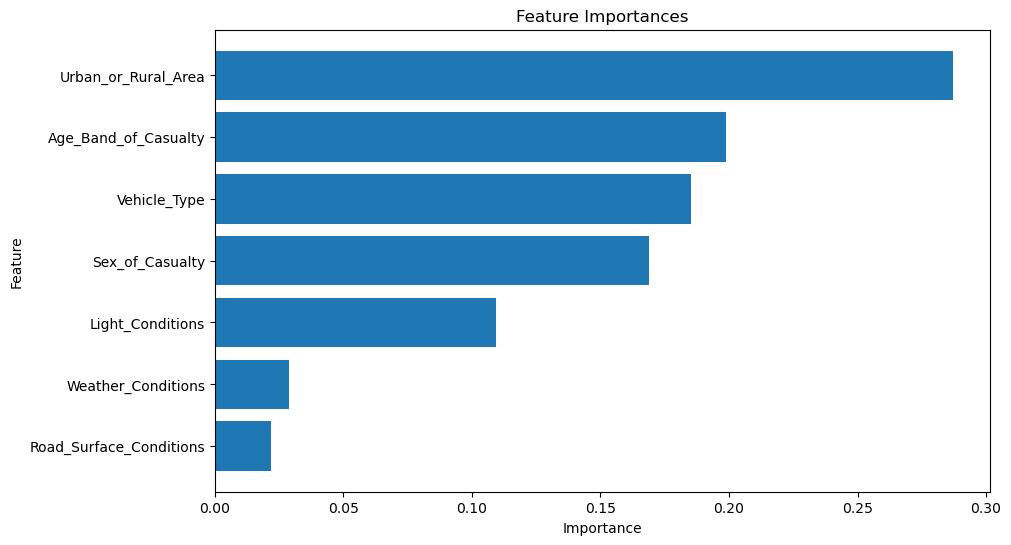

In [11]:
feature_importances  = clf.feature_importances_
sorted_idx = feature_importances.argsort()

df_feature = pd.DataFrame()
df_feature = df_model
df_feature.columns

def plot_impurity_metric_features(feature_importances, feature_names):
    # Sort the feature importances in descending order and get the indices
    sorted_idx = np.argsort(feature_importances)[::-1]

    # Arrange the feature names and their importances
    names = [feature_names[i] for i in sorted_idx]
    values = feature_importances[sorted_idx]

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(values)), values, align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    # Invert y-axis to have the most important feature on top
    plt.gca().invert_yaxis()  
    plt.show()
    
# Assuming clf_best is the trained model and X_train is the training data
feature_importances = clf.feature_importances_
feature_names = X_train_resampled.columns.tolist()

# Now use the function to plot
plot_impurity_metric_features(feature_importances, feature_names)

##### Most important features
The plot above clearly defines which features have the greatest impact and allows for recursive feature elimination

###### Re-configure the data to inlcude only the most important features.

In [12]:
# First, copy the model to avoid unnecesary risk of damage
df_rfe = df_model.copy()

# Drop two least important features

columns_to_remove = ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions']
df_rfe.drop(columns=columns_to_remove, inplace=True)
df_rfe.head()

,Vehicle_Type,Sex_of_Casualty,Age_Band_of_Casualty,Urban_or_Rural_Area,Casualty_Severity
0,9,1,7,1,2
1,11,1,7,1,3
2,11,1,9,1,3
3,9,1,9,1,3
4,9,1,6,1,3


In [13]:
# Split the data for modelling
# Define features and target
X = df_rfe.drop(columns=['Casualty_Severity'])
y = df_rfe['Casualty_Severity']

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Need to resample the data based on early calculations
# Creating a SMOTE object
smote = SMOTE()

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [14]:
# Now, fit the tree again with reduced numbers of features
bestdepth = -1
bestscore = 0

for i in range(10):
    clf_rfe = DecisionTreeClassifier(max_depth=i+1)
    clf_rfe = clf_rfe.fit(X_train_resampled, y_train_resampled )
    y_pred = clf_rfe.predict(X_test)
    trainscore = clf_rfe.score(X_train_resampled, y_train_resampled )
    valscore = clf_rfe.score(X_val, y_val)
    print('Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)
    if valscore > bestscore:
        bestscore = valscore
        bestdepth = i+1

print("Best Depth:", bestdepth, "with Validation Score:", bestscore)

Depth: 1 Train Score: 0.4363061108257599 Validation Score: 0.5456720864385459
Depth: 2 Train Score: 0.448566646650484 Validation Score: 0.668937819040674
Depth: 3 Train Score: 0.4654226684017353 Validation Score: 0.40306683314182473
Depth: 4 Train Score: 0.4813307916275453 Validation Score: 0.6119563578013462
Depth: 5 Train Score: 0.4857020314179194 Validation Score: 0.5992981299532449
Depth: 6 Train Score: 0.4899019356796692 Validation Score: 0.5714270165547417
Depth: 7 Train Score: 0.4913408795839429 Validation Score: 0.580238486548009
Depth: 8 Train Score: 0.4927169297471921 Validation Score: 0.5468118089557623
Depth: 9 Train Score: 0.4936197793827329 Validation Score: 0.5435745616421955
Depth: 10 Train Score: 0.49423998155116927 Validation Score: 0.5439073046417648
Best Depth: 2 with Validation Score: 0.668937819040674


###### Results - this has improved the accuracy slightly

In [15]:
# Now recalculate for the best depth
# Set the desired depth
bestdepth = bestdepth

# Initialize the Decision Tree Classifier with the best depth
clf = DecisionTreeClassifier(max_depth=bestdepth)

# Fit the model on the resampled training set
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the original (non-resampled) validation set
valscore = clf.score(X_val, y_val)

# Print the results
print("Depth:", bestdepth, "Validation Score:", valscore)

Depth: 2 Validation Score: 0.668937819040674


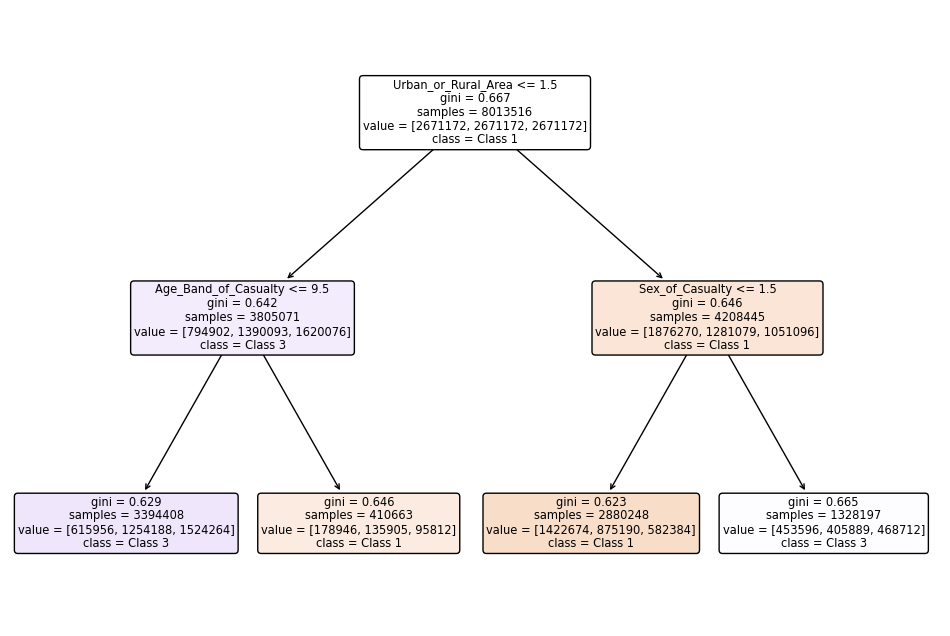

In [16]:
# Convert feature names from Pandas Index to a list
feature_names = X_train_resampled.columns.tolist()

# Visualize the decision tree
plt.figure(figsize=(12, 8))  # Adjust the size as needed
plot_tree(clf, filled=True, feature_names=feature_names, class_names=['Class 1', 'Class 2', 'Class 3'], rounded=True)
plt.show()

## Results: Not predicting class 2.

This is likely because the model is not deep enough

Change the model depth to 4 as this should output all 3 classes but offers a better accuracy than depth of 3

Depth: 4 Validation Score: 0.6119563578013462


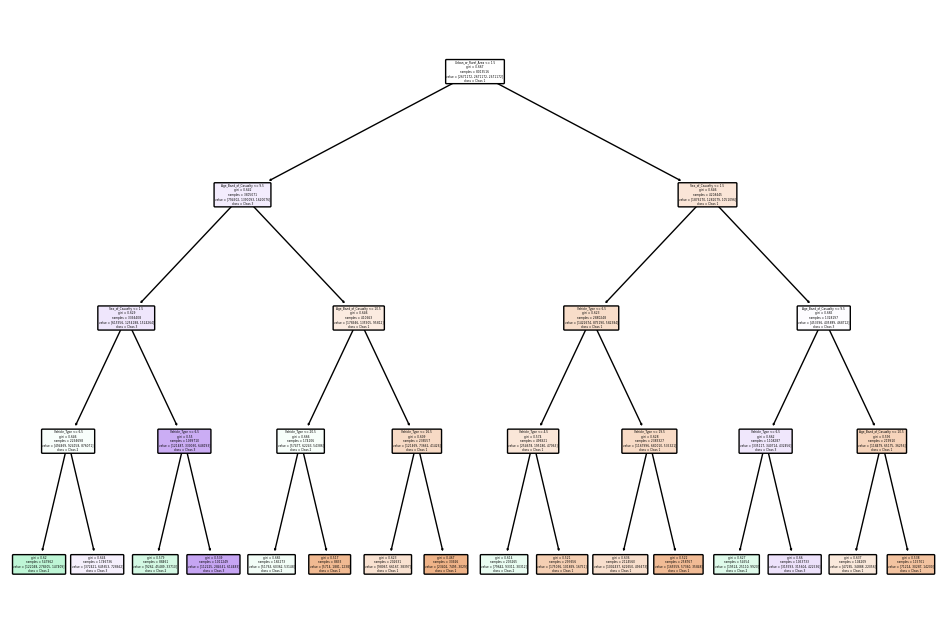

In [17]:
# Set the max depth to 4
bestdepth = 4

# Initialize the Decision Tree Classifier with the best depth
clf = DecisionTreeClassifier(max_depth=bestdepth)

# Fit the model on the resampled training set
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the original (non-resampled) validation set
valscore = clf.score(X_val, y_val)

# Print the results
print("Depth:", bestdepth, "Validation Score:", valscore)

# Convert feature names from Pandas Index to a list
feature_names = X_train_resampled.columns.tolist()

# Visualize the decision tree
plt.figure(figsize=(12, 8))  # Adjust the size as needed
plot_tree(clf, filled=True, feature_names=feature_names, class_names=['Class 1', 'Class 2', 'Class 3'], rounded=True)
plt.show()

##### Results - this is an improvement in that it is classifying all 3 output targets.

However, the accuract is not ideal. It is important to check all parameters to ensure they are optimised.

## Now - Hyperparameter Optimisation

In [18]:
# NEED BETTER HYPERPARAMETER TUNING/SELECTION

# Define the parameter grid
param_grid = {
    'max_depth': [4],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_rfe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the corresponding best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.48133079165929615


Validation Score with Best Parameters: 0.6119563578013462


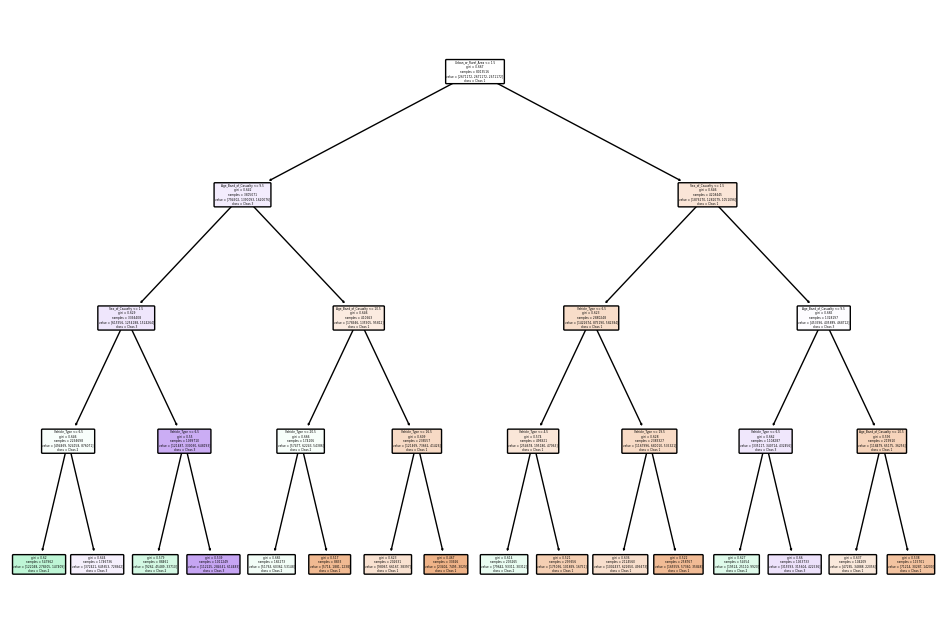

In [19]:
# Now run the model again using best parameters...


# Assuming grid_search is your GridSearchCV object
best_params = grid_search.best_params_

# Create a new classifier with the best parameters
best_clf = DecisionTreeClassifier(**best_params)

# Fit the classifier on the resampled training data
best_clf.fit(X_train_resampled, y_train_resampled)

# Now you can use best_clf to make predictions and evaluate its performance
# For example, evaluate on the validation set
validation_score = best_clf.score(X_val, y_val)
print("Validation Score with Best Parameters:", validation_score)

# Convert feature names from Pandas Index to a list
feature_names = X_train_resampled.columns.tolist()

# Visualize the decision tree
plt.figure(figsize=(12, 8))  # Adjust the size as needed
plot_tree(best_clf, filled=True, feature_names=feature_names, class_names=['Class 1', 'Class 2', 'Class 3'], rounded=True)
plt.show()

## Conclusion

The Hyperparameter optimsation has increased the acurracy of the model while ensuring that all classes are output.  It would be possible to increase the depth but this could likely lead to overfitting.

## RandomForest
##### It is worth checking if a Random Forest Approach improves the accuracy

In [20]:
rf_clf = ensemble.RandomForestClassifier()

# Fit the training sets
rf_clf = rf_clf.fit(X_train_resampled, y_train_resampled)

# Ouput the results
print('Full tree guess train/validation', rf_clf.score(X_train_resampled, y_train_resampled), rf_clf.score(X_val, y_val), rf_clf.score(X_test, y_test))

Full tree guess train/validation 0.4952056001385659 0.5422855712373219 0.5425747777696579


At this stage, it appears that RF is not having a positive impact on the accuracy score.  However, it is worth exploring the parameters slightly to determine if more investigation is required

In [21]:
# Utilise a 'for' loop looking at RF with different max_features 

np.random.seed(1)
for max_features in ["sqrt",  None]:
    # build the rf classifier wwith different arguments for max_features
    #fit to the training data
    rf_clf = rf_clf.fit(X_train_resampled,y_train_resampled)

    print ( f'Full tree guess train/validation {max_features}',rf_clf.score(X_train_resampled, y_train_resampled)
           ,rf_clf.score(X_val, y_val))

Full tree guess train/validation sqrt 0.4952056001385659 0.5422684676251945
Full tree guess train/validation None 0.49520472661438497 0.5422809066158326


##### Output this for visual representation

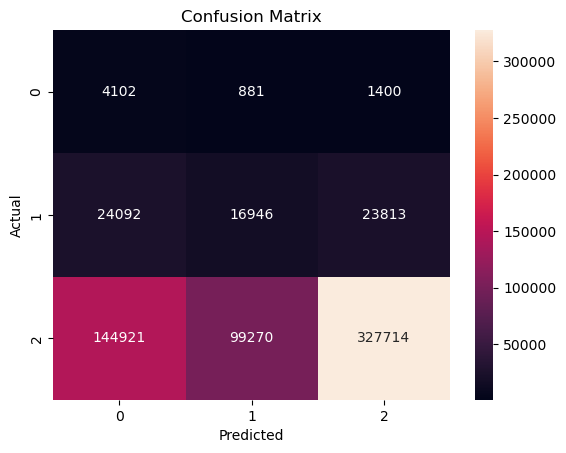

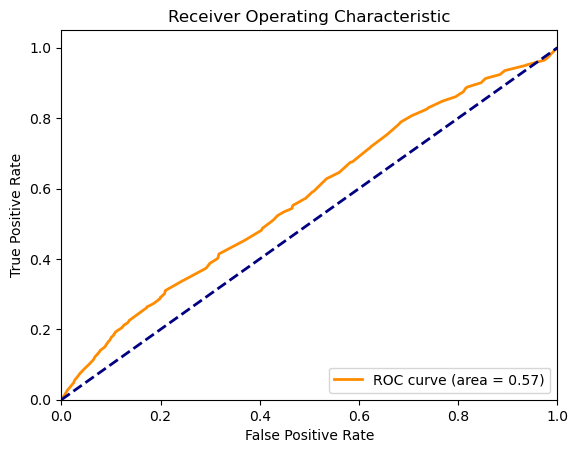

In [22]:
# Predictions
y_pred = rf_clf.predict(X_val)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, rf_clf.predict_proba(X_val)[:, 1], pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



A Receiver Operating Characteristic (ROC) curve is a visualisation of the performance of the model, based heavilty on the confusion matrix.

It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for the model. True Positive Rate assesses how well the model correctly identifies positive cases among all actual positives. False Positive Rate gauges the model's tendency to mistakenly classify negative cases as positive.

##### Random Forest Conclusion

It can be concluded that RF is unlikle yo timprove the model and therefore no further analysis is required on this arm of the project

## Summary:

__This code has:__

Imported the various datasets, merged them and manipulated them to remove missing vlaues and draw out the most important features.

Used Recursive Feature Importance (RFE) to determine which features are most important and iteratively remove the least important features in an ammempt to improve accuracy.

Used a GridSearch to progressively search every combination of the available hyper parameters to ensure the model is working at its most effective.

Used Decision Trees to determine the accuracy of the predicted model outputs

Output the decision tree results as an accuracy score

Concluded with using a Random Forest Approch to determine if this improves accuracy.

__The code has concluded:__

The most important features to determine severity of injursy in road traffic collisions are:
Urban or rural location
Age of casualties
Vehicle type

It can predict accuracy of up to 70% but in reality is reliably achieving 60%.  This in itself is not sufficient and for the next iteration, I wil employ a nubmer of adidtional techniques to improve this including: SGB boosting or SHAP
